In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from arcgis.gis import GIS
from arcgis.geocoding import geocode

In [2]:
#open resturants file
all_resturants_info = pd.read_csv("TA_restaurants_curated.csv")

#remove blank rows
all_resturants_info.drop("Unnamed: 0", axis = 1, inplace = True)
all_resturants_info.dropna(how = "any", inplace = True)

#creat dataframe of number of resturants and avarage rate per city
cities_group = all_resturants_info.groupby("City")
cities = cities_group.agg({"Name": "count","Rating": "mean" })
cities.rename(columns = {"Name": "rest counter", "Rating": "rating avg"}, inplace = True )
cities

,rest counter,rating avg
City,,
Amsterdam,2426,4.125103
Athens,1166,4.228988
Barcelona,5079,4.019197
Berlin,3438,4.142088
Bratislava,426,4.083333
Brussels,2014,3.899454
Budapest,1640,4.101829
Copenhagen,1273,4.002357
Dublin,1460,4.085616


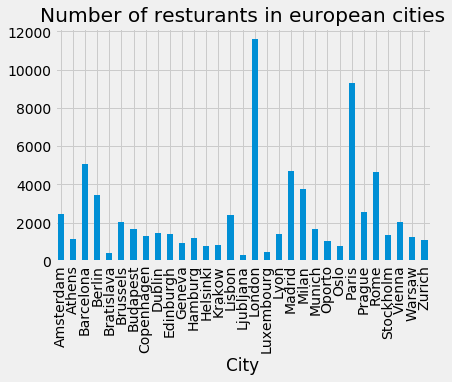

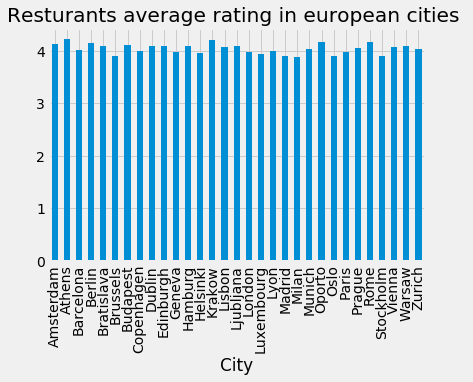

In [3]:
#visualisation of cities dataframe
plt.style.use("fivethirtyeight")
cities["rest counter"].plot(kind = "bar", title = "Number of resturants in european cities")
plt.show()
cities["rating avg"].plot(kind = "bar", title = "Resturants average rating in european cities ")
plt.show()


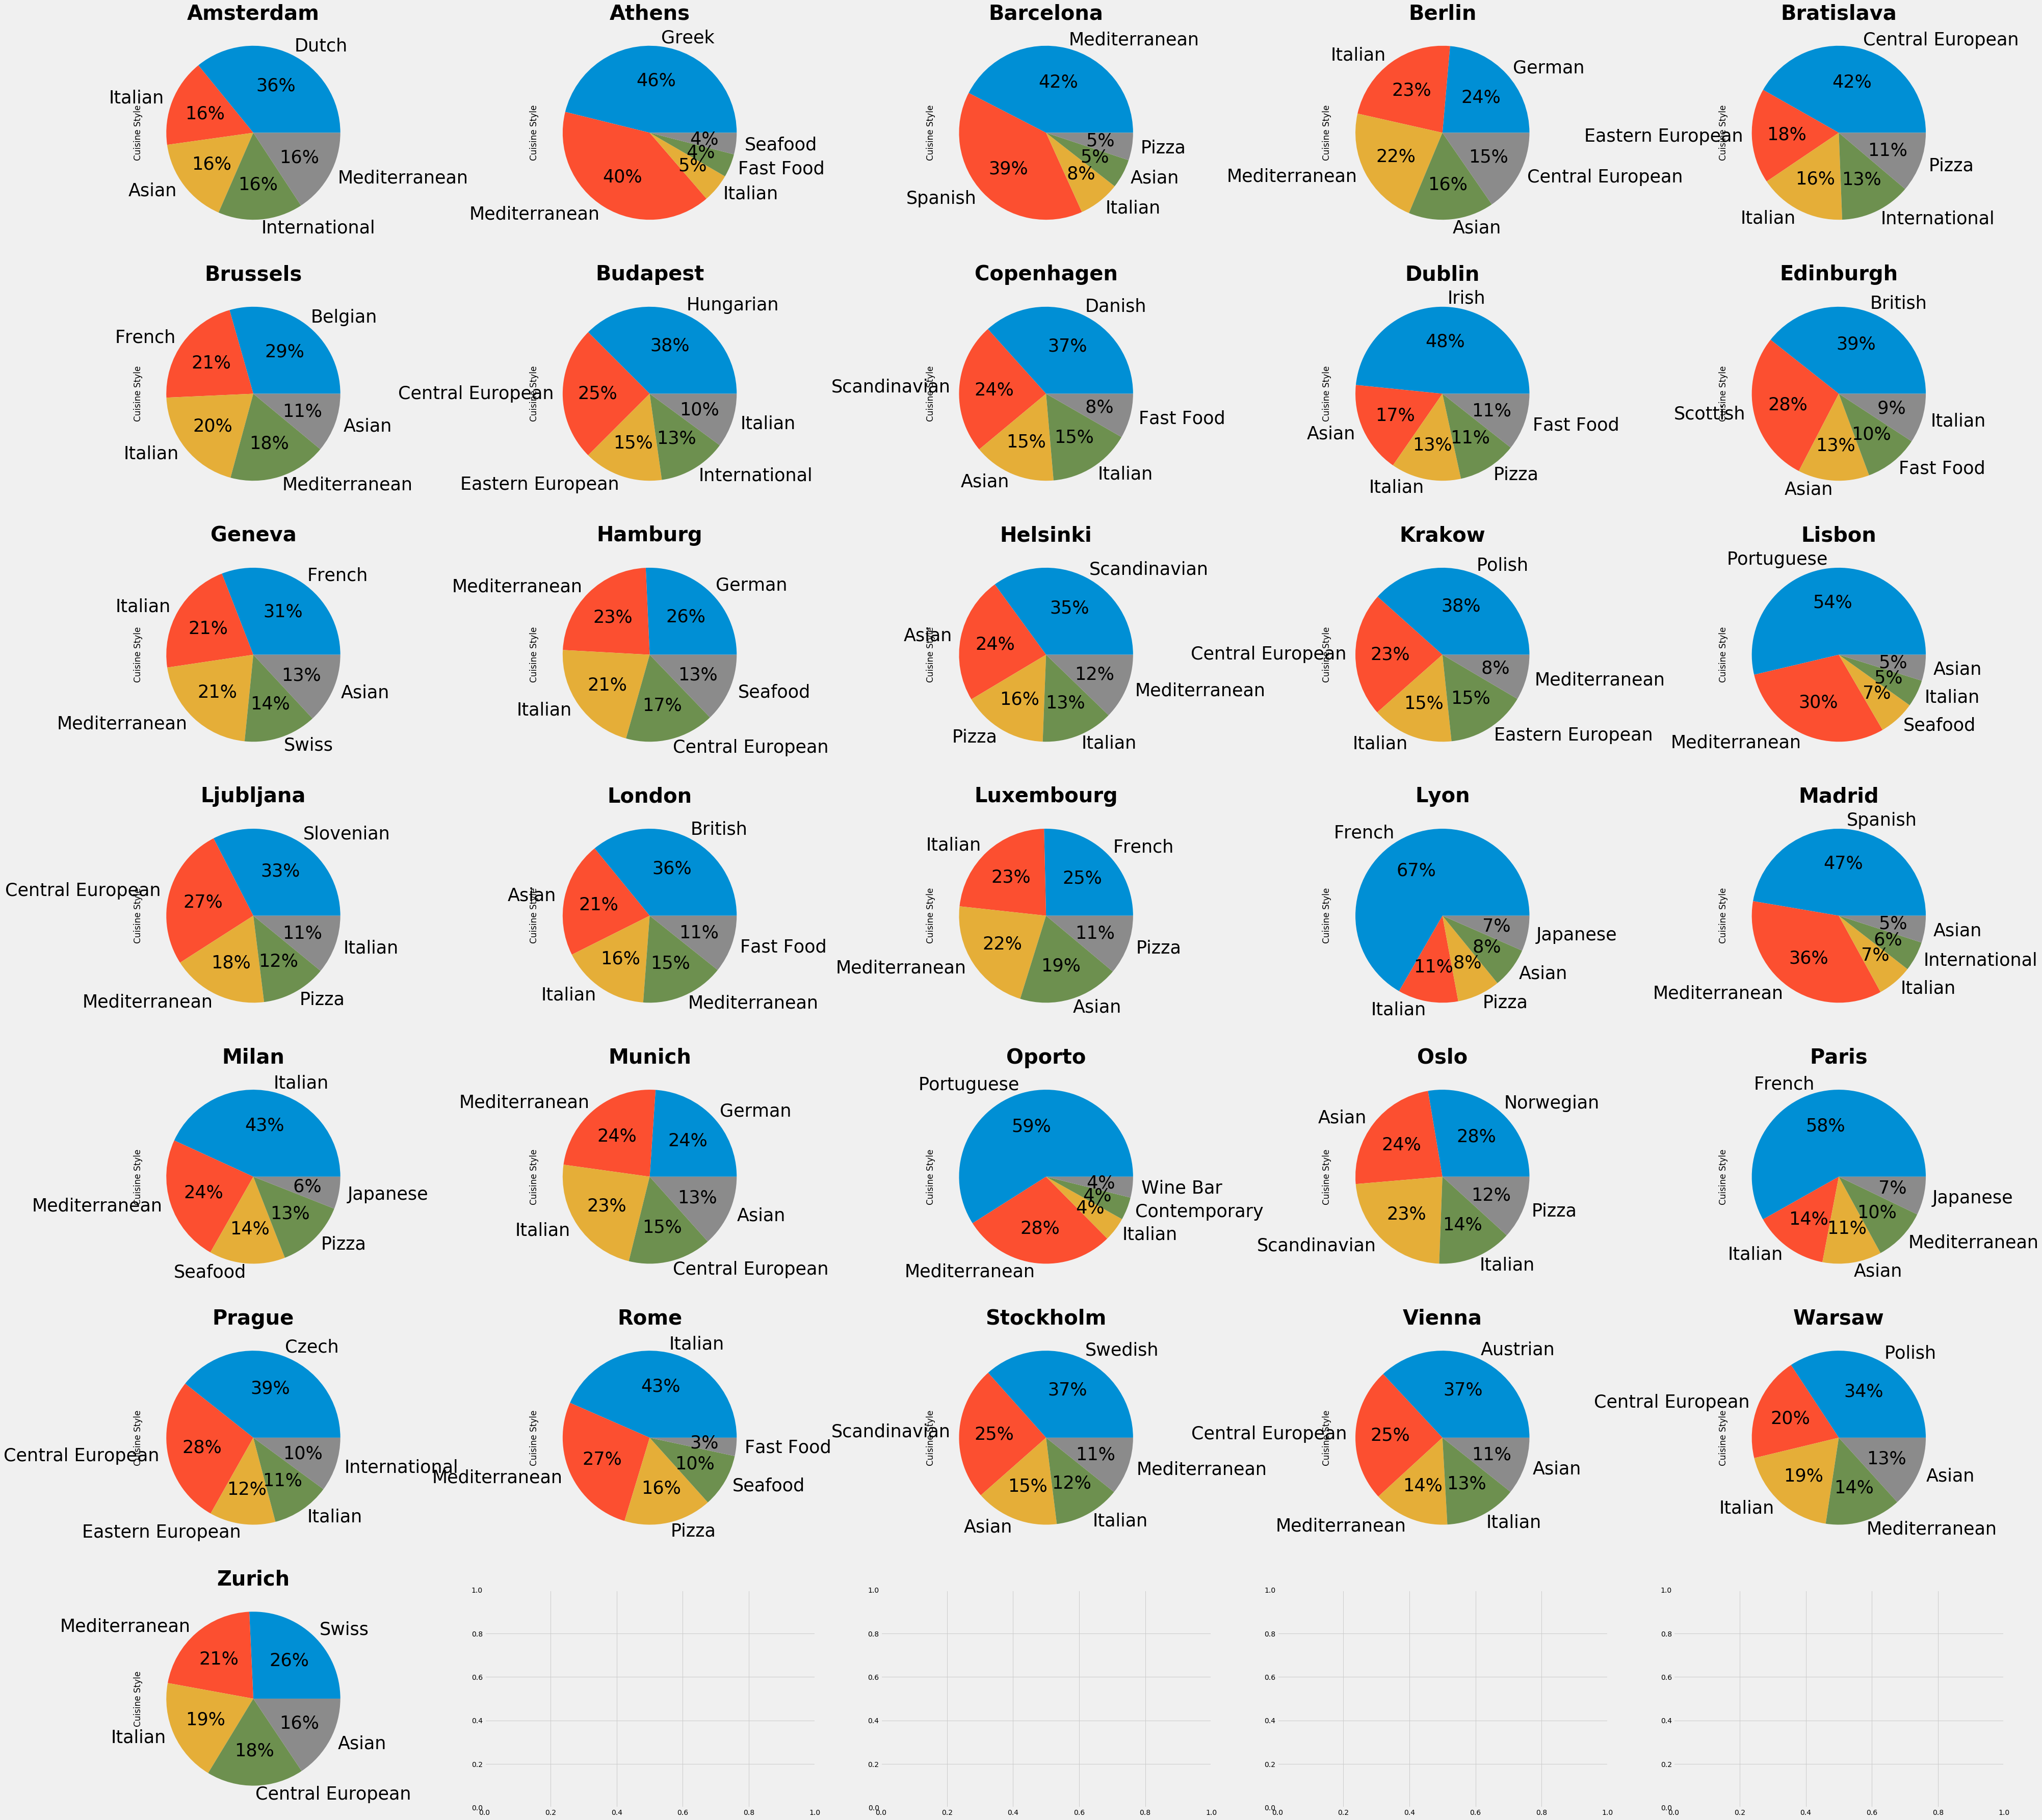

In [4]:
#Visual display of 5 most common cuisines in european cities
all_resturants_info["Cuisine Style"] = all_resturants_info["Cuisine Style"].str.strip("[]").str.replace("'", "").str.split(",")
d = {}
fig, ax = plt.subplots(ncols = 5, nrows = 7)
for city,a in zip(cities_group.groups,ax.flatten()):
    c = cities_group.get_group(city)
    cuisine_counts = c.explode("Cuisine Style")["Cuisine Style"].str.strip().value_counts()
    cuisine_counts = cuisine_counts.drop(["Vegetarian Friendly", "European", "Gluten Free Options", "Bar", "Cafe", "Vegan Options", "Pub"])
    plt_cuisine = cuisine_counts.head().plot(kind='pie', title=city,ax=a, figsize = (60, 60),  fontsize = 35, autopct='%2.0f%%')
    plt_cuisine.set_title(city, fontweight='bold', fontsize=40)
    d[city] = [cuisine_counts.index.tolist()[0]]
plt.show()  
common_cuisine = pd.DataFrame(d)
common_cuisine = common_cuisine.T
cities =  cities.merge(common_cuisine, right_index=True, left_index=True,  how='inner') 
cities.rename(columns = {0: "common_cuisine"}, inplace = True )


In [5]:
#for each city add it country in dataframe cities
countries_Expenses = pd.read_csv("spending on eating out.csv", usecols= ["Value", "TIME", "GEO","UNIT"]) 
countries_size = pd.read_csv("table-1.csv", usecols=["Urban_erea", 'State']) 
cities =  cities.merge(countries_size, right_on="Urban_erea", left_index=True,  how='inner') 
cities.rename({"State" : "Country", "Urban_erea":"City"}, axis=1, inplace=True)


In [6]:
#reomove unnecessery data from countries Expenses dataframe
Percentage = countries_Expenses["UNIT"] == "Percentage of total"
countries_Expenses = countries_Expenses[Percentage]

In [7]:
#remove unnecessery data from countries name from countries Expenses dataframe
def split_countries(string):
    list = string.strip().split()
    return list[0].strip()
countries_Expenses["GEO"] = countries_Expenses["GEO"].apply(split_countries)

In [8]:
#creat new dataframe only with the relevante cities we work on 
countries_Expenses_merge = countries_Expenses.merge(cities, left_on="GEO", right_on="Country", how="inner")
countries_Expenses = countries_Expenses_merge.copy()
countries_Expenses["Value"] = pd.to_numeric(countries_Expenses["Value"], errors='coerce').fillna(0)
countries_Expenses["TIME"] = pd.to_datetime(countries_Expenses["TIME"], format='%Y')
countries_Expenses["TIME"] = countries_Expenses["TIME"].dt.year
no_2019 = countries_Expenses["TIME"] != 2019


In [9]:
#create new dataframe of expensess value by years per country
countries_Expenses_groups = countries_Expenses[no_2019].groupby("GEO")
lists_of_countries = list(countries_Expenses_groups.groups)

#create a dataframe with the first country data
first_country = lists_of_countries[0]
country_expenses = countries_Expenses_groups.get_group(first_country)
country_expenses = country_expenses[["Value","TIME"]]
country_expenses.set_index("TIME", inplace = True)
country_expenses.rename({"Value" : first_country}, axis = 1, inplace = True)

In [10]:
#add the other countries to the dataframe
for country in lists_of_countries[1:]:
    country2= countries_Expenses_groups.get_group(country)
    
#check if there are values about the country
    if country2["Value"].mean() == 0:
        continue
    country2 = country2[["Value","TIME"]]
    country2.rename({"Value" : country}, axis=1, inplace=True)
    country2.set_index("TIME", inplace = True)
    country_expenses = country_expenses.merge(country2, left_index = True, right_index= True, how = "left")    

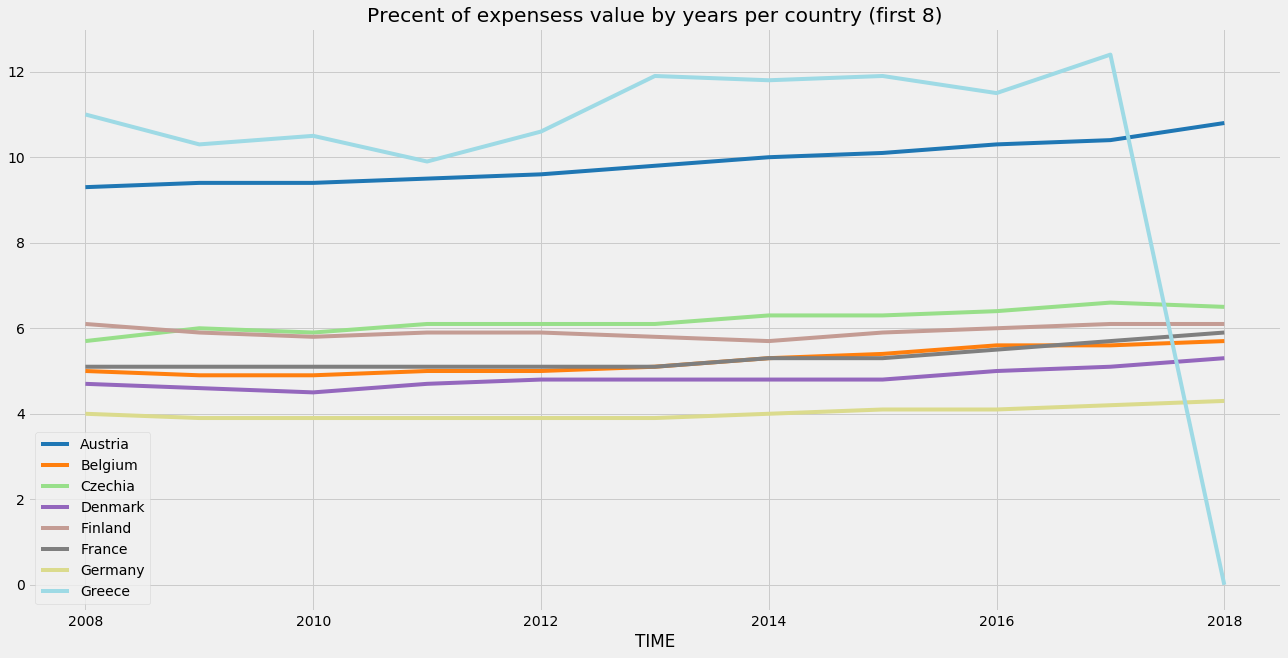

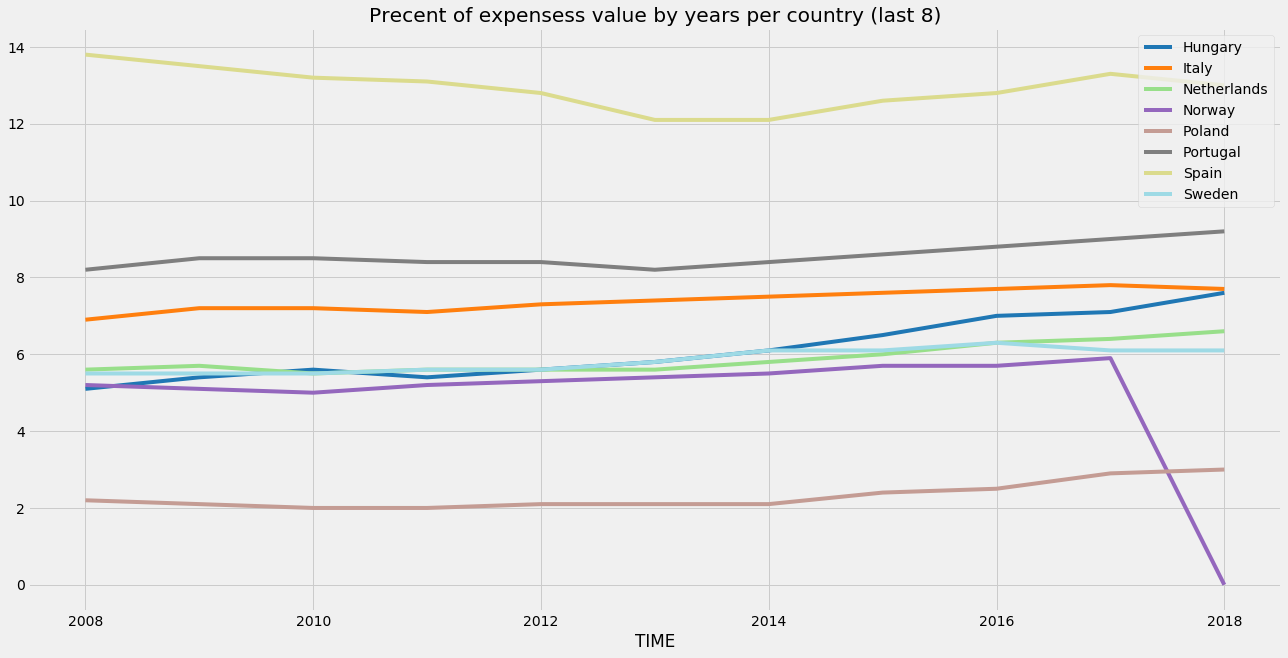

In [11]:
#visual display of expensess value by years per country

#create a list of columns names
lists_of_countries_names = list(country_expenses.columns)

#split to 2 dataframe of 8 countris to a clear visual display
country_expenses[lists_of_countries_names[:8]].plot(figsize=(20,10), title = "Precent of expensess value by years per country (first 8)", colormap = "tab20")
plt.show()
country_expenses[lists_of_countries_names[8:]].plot(figsize=(20,10), title = "Precent of expensess value by years per country (last 8)", colormap = "tab20")
plt.show()

In [12]:
#change index of cities dataframe
cities.set_index("City", inplace = True)

In [13]:
#open file of cities info
cities_info = pd.read_csv("size.csv", usecols = ["City", "Population", "Area (km2)"])

#create string that can change to numeric
cities_info["Population"] = cities_info["Population"].str.replace(",", "")
cities_info["Area (km2)"] = cities_info["Area (km2)"].str.replace(",", "")

#function get string and remove "["- "[]" indicate on notes in the file 
def delete_notes(string):
    if "[" in string:
        city = string.split("[")
        return city[0]
    return string

#apply function on columns and change to correct type
cities_info["Population"] = cities_info["Population"].apply(delete_notes)
cities_info["Population"] = cities_info["Population"].astype("int")

cities_info["Area (km2)"] = cities_info["Area (km2)"].apply(delete_notes)
cities_info["Area (km2)"] = cities_info["Area (km2)"].astype("float")

cities_info["City"] = cities_info["City"].apply(delete_notes)

In [14]:
#merge cities info with cities dataframe
cities = cities.merge(cities_info,how="inner", left_index= True, right_on = "City")
cities = cities.set_index("City")

In [15]:
#create new columns of density of resturants. the parameter calculated by number of resturants / size of city.
cities["resturants density"] = cities["rest counter"]/cities["Area (km2)"]

In [16]:
#create new columns of SN scale. the parameter calculated by number of Population / resturants density.

#as SN scale is higher there are more citizens per resturant- more potential clients for a new resturant.
cities["SN scale"] = cities["Population"]/cities["resturants density"]
cities.sort_values("SN scale", ascending = False, inplace = True)
pd.set_option('float_format', '{:f}'.format)

In [17]:
#add to cities dataframe expenses precent on resturants in 2018 (according to the year the resturants file was posted)
only_2018 = countries_Expenses_merge["TIME"] == 2018
countries_Expenses_merge = countries_Expenses_merge[only_2018]
countries_Expenses_merge = countries_Expenses_merge[["City","Value" ]]
cities = cities.merge(countries_Expenses_merge, left_index = True, right_on = "City", how = "inner")
cities = cities.set_index("City")
cities = cities.rename({"Value" : "counrty rest expenses 2018"}, axis = 1)

In [18]:
#the function gets price by characters and return scale by string
def price_scale(price):
    if price == "$":
        return "cheap"
    if price == "$$ - $$$":
        return "medium"
    if price == "$$$$":
        return "expensive"
    else:
        return 
    
#apply function on resturants dataframe and group by cities
all_resturants_info["price"] = all_resturants_info["Price Range"].apply(price_scale)
new_cities_group = all_resturants_info.groupby("City")

#add the commone price to the city dataframe
d={}
for city in new_cities_group.groups:
    group = cities_group.get_group(city)
    price = group["price"].value_counts()
    d[city] = [price.index.tolist()[0]]
common_price = pd.DataFrame(d)
common_price = common_price.T
cities = cities.merge(common_price, right_index=True, left_index=True,  how='inner') 
cities.rename(columns = {0: "common_price"}, inplace = True )

In [19]:
#check how many resturants per city are friendly (Vegetarian Friendly, Gluten Free Options, Vegan Options)
d={}
for city in cities_group.groups:
    c = cities_group.get_group(city)
    friendly_counts = c.explode("Cuisine Style")["Cuisine Style"].str.strip()
    friendly_counts = friendly_counts.dropna()   
    friendly_counts = friendly_counts[(friendly_counts.str.contains("Vegetarian Friendly")) | (friendly_counts.str.contains("Gluten Free Options")) | (friendly_counts.str.contains("Vegan Options"))]
    num_rest = len(friendly_counts)
    d[city] = [num_rest]
friendly_rest = pd.DataFrame(d)
friendly_rest = friendly_rest.T



In [20]:
#add to dataframe cities the precantage of friendly resturants from the number of resturants per city
friendly_rest = friendly_rest.merge(cities["rest counter"], left_index = True, right_index = True, how = "inner")
friendly_rest["friendly precent"] = (friendly_rest[0]/friendly_rest["rest counter"]) * 100
cities = cities.merge (friendly_rest["friendly precent"], left_index = True, right_index = True, how= "inner")

In [21]:
#open coordinates cities file and merge to cities dataframe
coordinates = pd.read_csv("worldcities.csv", usecols = ["city", "country", "lat", "lng"], index_col = "city")
cities = cities.merge(coordinates, left_on = [cities.index,"Country"], right_on = [coordinates.index,"country"], how= "inner")
cities.rename({"key_0" : "City"}, axis = 1, inplace = True)
cities.set_index("City", inplace = True)
cities.drop("country", axis = 1, inplace = True)

#remove the cities with missing information for accurate analytics
cities.drop(["Dublin", "Athens"], inplace = True)

In [22]:
#cities dataframe- full information
cities

,rest counter,rating avg,common_cuisine,Country,Population,Area (km2),resturants density,SN scale,counrty rest expenses 2018,common_price,friendly precent,lat,lng
City,,,,,,,,,,,,,
Rome,4654,4.161689,Italian,Italy,4355725,1285.000000,3.621790,1202644.311345,7.7,medium,101.654491,41.896000,12.483300
Berlin,3438,4.142088,German,Germany,3644826,891.120000,3.858066,944728.721675,4.3,medium,78.155905,52.521800,13.401500
Budapest,1640,4.101829,Hungarian,Hungary,1752286,525.140000,3.122977,561094.798805,7.6,medium,80.365854,47.500000,19.083300
Madrid,4685,3.894771,Spanish,Spain,3141991,604.300000,7.752772,405273.246809,13,medium,57.011740,40.400000,-3.683400
Vienna,2025,4.063457,Austrian,Austria,1889083,414.650000,4.883637,386818.896765,10.8,medium,75.901235,48.200000,16.366600
Munich,1679,4.033651,German,Germany,1471508,310.700000,5.403927,272303.475640,4.3,medium,75.521144,48.129900,11.575000
Stockholm,1364,3.894428,Swedish,Sweden,942370,188.000000,7.255319,129886.774194,6.1,medium,87.536657,59.350800,18.097300
Brussels,2014,3.899454,Belgian,Belgium,1212352,162.400000,12.401478,97758.671698,5.7,medium,52.780536,50.833300,4.333300
Milan,3737,3.874766,Italian,Italy,1366037,181.760000,20.560079,66441.232304,7.7,medium,74.846133,45.470000,9.205000


In [23]:
#get input from the user (city name)
import sys 
print("Hello! If you want to open a new resturant in europe you are in the right place!\nwe can give you informtaion about the following cities:")
for city in list(cities.index.values):
    print(city)
chef_input = str(input("So, where do you want to open your resturant? (Please write the fisrt letter as capital letter)"))
class color:
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'
    
#checking if the city in our dataframe if not ask for a new input. 
#if after two times the input if wrong, exit the code.
if chef_input not in list(cities.index.values):
    print(color.BOLD + color.RED + "We are sorry, we cant give you informtaoin about this city." + color.END)
    chef_input = str(input("Please choose a new city from the list above."))
    if chef_input not in list(cities.index.values):
        sys.exit("Sorry we cant help you.")

Hello! If you want to open a new resturant in europe you are in the right place!
we can give you informtaion about the following cities:
Rome
Berlin
Budapest
Madrid
Vienna
Munich
Stockholm
Brussels
Milan
Amsterdam
Copenhagen
Barcelona
Paris
Lisbon
Lyon
So, where do you want to open your resturant? (Please write the fisrt letter as capital letter)Paris


In [24]:
#create a new information file for the user
rest_report = open(f"{chef_input} restaurants analysis report.txt", "w")
city_informtaion = cities.loc[chef_input]
rest_report.write(f"{chef_input} restaurants analysis report\n")

34

In [25]:
#add SN scale information to the file
city_SN_scale = city_informtaion["SN scale"]
rest_report.write(f"The SN scale of {chef_input} (number of Population / resturants density) is: {city_SN_scale}.\n")
cities.sort_values(by="SN scale", ascending=False, inplace = True)

#find the city SN scale rank and add it to the file
counter = 1
for city in list(cities.index.values):
    if city == chef_input:
        rest_report.write(f"The rate of {chef_input} is {counter} in the SN scale (from 15 cities).\n")
        break
    counter = counter + 1

In [26]:
#add counrty precantage expenses on resturants to the file
city_expenses = city_informtaion["counrty rest expenses 2018"]
city_country =  city_informtaion["Country"]
rest_report.write(f"{city_country} precantage expenses on resturants in 2018 is: {city_expenses}.\n")

58

In [27]:
#add city common cuisine to the file
city_common_cuisine = city_informtaion["common_cuisine"]
rest_report.write(f"The most common cuisine of resturants in {chef_input} is: {city_common_cuisine}.\n")

59

In [28]:
#add city average rate of resturants that contians the common cuisiune
city_resturants = cities_group.get_group(chef_input)
city_cuisine_counts = city_resturants.explode("Cuisine Style")["Cuisine Style"].str.strip()
city_cuisine_counts = city_cuisine_counts.str.contains(city_common_cuisine)
only_common_cuisine_rest = city_cuisine_counts[city_cuisine_counts == True]
rest_info_copy = all_resturants_info.copy()
rest_info_copy = rest_info_copy.merge(only_common_cuisine_rest, left_index = True, right_index = True, how= "inner" )
mean_rate_cuisine = rest_info_copy["Rating"].mean()
rest_report.write(f"The average rate of resturants that contains the common cuisine in {chef_input} is: {mean_rate_cuisine}.\n")

96

In [29]:
#add city average price of resturants that contians the common cuisiune
cuisine_counts = rest_info_copy["price"].value_counts()
most_common_price = cuisine_counts.index.tolist()[0]
rest_report.write(f"The most commom price of resturants that contains the common cuisine in {chef_input} is: {most_common_price}.\n")

90

In [30]:
#add city precent of friendly resturants (restuants that contains friendly kitchens\ city's resturant's number). 
#friendly kitchen- kitchen that contains vegan, vegetrian and glutten free options.
city_friendly = city_informtaion["friendly precent"]
rest_report.write(f"The precentage number of friendly resturants (restuants that contains friendly kitchens\ city's resturant's number) in {chef_input} is: {city_friendly}.\n")
rest_report.write(f"*friendly kitchen- kitchen that contains vegan, vegetrian and glutten free options.\n\n")

85

In [31]:
#add a summery to the file
rest_report.write("SUMERRY:\n Dear customer,\n Our recommendations about your future resturant based on the information are:\n")
rest_report.write(f"-{city_common_cuisine} is the best kitchen for your new resturant in {chef_input}.\n")
rest_report.write(f"-The resturnt pricing need to be {most_common_price}.\nPlease consider the following parameters:\n")
if counter < 7:
    rest_report.write(f"{chef_input}'s SN scale rank is high.\n")
else:
    rest_report.write(f"{chef_input}'s SN scale rank is low.\n")
if city_friendly > 75:
    rest_report.write(f"The precentage of friendly resturants in {chef_input} is high.\n")
else:
    rest_report.write(f"The precentage of friendly resturants in {chef_input} is low.\n")
if float(city_expenses) >= 7:
    rest_report.write(f"{city_country} precantage expenses on resturants in 2018 is above the average in europe countries (7%)\n")
else:
    rest_report.write(f"The counrty precantage expenses on resturants in 2018 is below the average in europe countries (7%)\n")
rest_report.write("Thank you for trusting us.\nWe wish you good luck with your new resturant!")
rest_report.close()
print("Your report is ready in a TXT file")

Your report is ready in a TXT file


In [32]:
#find resturants in the center of the chef's city choice
center_coordinates = []
center_coordinates.append(cities.loc[chef_input]["lng"])
center_coordinates.append(cities.loc[chef_input]["lat"])

gis = GIS()
resturants_in_center = geocode(address=None,
                     location=center_coordinates,
                     category="Food",
                     out_fields="Place_addr, PlaceName",
                     max_locations=100,
                     as_featureset=True)

In [33]:
g_df = resturants_in_center.sdf
g_df = g_df.rename(columns = {"PlaceName" : "Name"})

In [34]:
#merge trip advisor's data with the resturants in the city center
mask = all_resturants_info["City"] == chef_input
resturants_in_chef_City = all_resturants_info[mask]

chef_center_rest= resturants_in_chef_City.merge(g_df, how= "inner")

In [35]:
#the function gets dic with info from GIS
#return only coordinates of the resturants
def get_coordiantes (dic):
    info_lst = list(dic.values())
    info_lst= info_lst[:2]
    coordiant_lst=[]
    coordiant_lst.append(info_lst[1])
    coordiant_lst.append(info_lst[0])
    return(coordiant_lst)

#save the coordinates to a new column
chef_center_rest["Coordinates"] = chef_center_rest["SHAPE"].apply(get_coordiantes)

In [36]:
#create a map of the city
g_map = gis.map()
g_map.center = center_coordinates[::-1]
g_map.zoom = 11

#drow on map the resturants
for index,row in chef_center_rest.iterrows():
    g_map.draw(row["Coordinates"], popup = {"title" : row['Name'] , "content" : row['Place_addr']})
    
print(color.BOLD + color.RED + "The resturants located in the center of the city you chose. click on the circle to get the resturant info." + color.END)
print("*Base on the data from Trip Advisor")
g_map


The resturants located in the center of the city you chose. click on the circle to get the resturant info.
*Base on the data from Trip Advisor


MapView(layout=Layout(height='400px', width='100%'))